# Deep Convolutional Generative Adversarial Networks (DCGAN)

A generative adversarial network (GAN) is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. Goodfellow proposed a design of two neural networks contesting with each other in a game (in the form of a zero-sum game, where one agent's gain is another agent's loss).

<img src='https://i1.wp.com/bdtechtalks.com/wp-content/uploads/2018/05/GANs.png?resize=696%2C304&ssl=1' />

Given a training set, this technique learns to generate new data with the same statistics as the training set. For example, a GAN trained on photographs can generate new photographs that look at least superficially authentic to human observers, having many realistic characteristics. Though originally proposed as a form of generative model for unsupervised learning, GANs have also proven useful for semi-supervised learning, fully supervised learning, and reinforcement learning.

The core idea of a GAN is based on the "indirect" training through the discriminator, which itself is also being updated dynamically. This basically means that the generator is not trained to minimize the distance to a specific image, but rather to fool the discriminator. This enables the model to learn in an unsupervised manner.


## Artist versus Critics

As an analogy, we can consider the scenario: two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.

<img src='https://www.tensorflow.org/tutorials/generative/images/gan1.png' />

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.

<img src='https://www.tensorflow.org/tutorials/generative/images/gan2.png' />

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the generator as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.


### Reference
- Wikipedia entry: [Generative Adversarial Networks](https://en.wikipedia.org/wiki/Generative_adversarial_network)
- TensorFlow tutorial: [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)
- Goodfellow, Ian; Pouget-Abadie, Jean; Mirza, Mehdi; Xu, Bing; Warde-Farley, David; Ozair, Sherjil; Courville, Aaron; Bengio, Yoshua (2014). [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661). *Proceedings of the International Conference on Neural Information Processing Systems (NIPS 2014)*. pp. 2672–2680.



## Prepare the Data

In [1]:
# load libraries
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
# Prepare data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

(60000, 28, 28, 1)


(array([38847859.,   571880.,   514157.,   438029.,   446644.,   503214.,
          469607.,   518723.,   611860.,  4118027.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

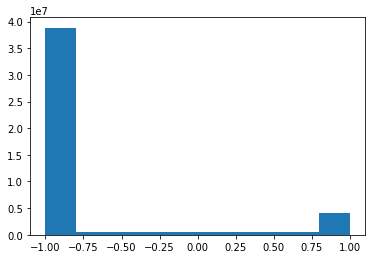

In [3]:
# Take a peak at the data
print(train_images.shape)
plt.hist(train_images.flatten())

As shown above, the dataset contains 60,000 gray-scale images of 28x28, and the about 1/8 of the domain having writings trails.


## Setup the model

This model is defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator
T
he generator uses [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (upsampling) layers to produce an image from a random seed. Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation for each layer, except the output layer which uses `tanh` (to fit the input data using -1 as black and 1 as white).


In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

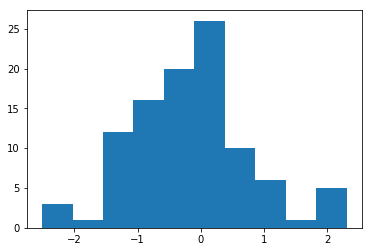

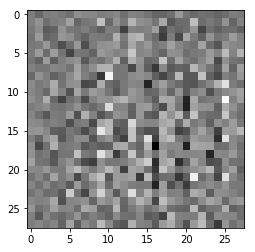

In [5]:
# Create an image for testing

generator = make_generator_model()

noise = tf.random.normal([1, 100])
plt.hist(noise)
plt.show()

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

### The Discriminator

The discriminator is a simple CNN-based image classifier.

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


### Define the loss and optimizers

Define loss functions and optimizers for both generator- and discriminator- models.

The discriminator and the generator optimizers are different since we will train two networks separately.


### Discriminator loss

This method quantifies how well the discriminator is able **to distinguish real images from fakes**. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.


### Generator loss

The generator's loss quantifies how well it was able **to trick the discriminator**. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [7]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [8]:
generator = make_generator_model()
discriminator = make_discriminator_model()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

<img src='https://www.oreilly.com/library/view/generative-adversarial-networks/9781789139907/assets/49ed7628-9f59-4024-b445-6a97912d251c.png' />

In [9]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# The main training loop
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Generate and save images
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they **train at a similar rate**).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

`[Reference]` Each epoch takes around 7 seconds on a PC configuration of:
- CPU: AMD Ryzen 3700x (8C16T) 
- RAM: 64GB DDR4 
- GPU: NVIDIA RTX2060s

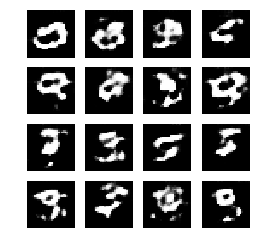

In [10]:
train(train_dataset, EPOCHS)

The generator doesn't seem very good after 20 epochs. Let's restore the check-point and do another 20 epochs.

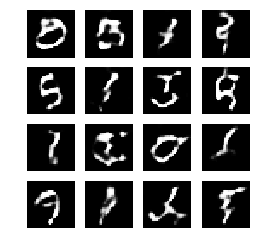

In [11]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

train(train_dataset, EPOCHS)

You can keep training until you get a satisfied generator.